In [1]:
using Agents
# using InteractiveDynamics
using GLMakie
using Plots
using Random
using Distributions
using Statistics
using StatsBase
using DataFrames, DataFramesMeta


In [2]:
function GiniCoefficientJulia(x)
    n = length(x)
    shift = abs(minimum(x, init=0))
    x = x .+ shift
    # If all values are zero, return 0
    if sum(x) == 0
        return 0
    end
    
    # Sort the values
    x = sort(x)
    
    # Calculate the rank of each value
    rank = collect(1:n)
    
    # Calculate the Gini coefficient using the formula
    return (1 / n) * (2 * sum(rank .* x) / sum(x) - (n + 1))
end


GiniCoefficientJulia (generic function with 1 method)

In [3]:
@agent SchellingAgent GridAgent{2} begin
    remain::Bool 
    group::Int
    money::Float64
    dispersed_agent::Bool
    money_change::Float64
    pos_neg_neutral_change::Int64
    distance_from_injection::Float64
    k1::Float64
    k2::Float64

    potential_energy::Int
    kinetic_energy::Float64 
    
end

In [ ]:
#=
Each agent starts with money and the $1,000,000 is dispered throughout the agents randomly in increments of $1,000
=#

In [4]:
seed = 123;

MEAN_MONEY = 60_000
SD_MONEY = 5_000;
SHAPE_PARAMETER_XI = 0.5
MONEY_DISTRIBUTION = GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI)

GeneralizedPareto{Float64}(μ=60000.0, σ=5000.0, ξ=0.5)

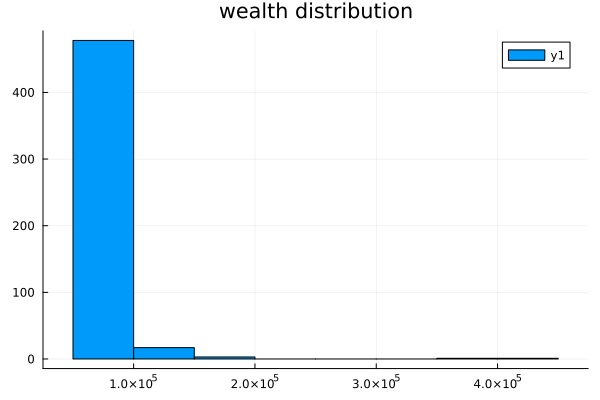

In [5]:
data = [ rand(MONEY_DISTRIBUTION,1)[1] for _ in 1:500 ]
Plots.histogram( data, bins=12, title="wealth distribution" )

In [6]:
const NN = 13;
const GRID_DIM = (NN,NN);
TOTAL_AGENTS = round( Int, 0.80*prod(GRID_DIM) );

AGENTS_MONEY = rand(MONEY_DISTRIBUTION, TOTAL_AGENTS)
MAX_MONEY = maximum( AGENTS_MONEY );
MOVEMENT_ENERGY_MIN_REQUIREMENT = 0.01



KineticEnergy(money) = 2 * money / MAX_MONEY
InvKineticEnergy(kinetic_energy) = (1/2) * MAX_MONEY * kinetic_energy #returns the money and money is then effectively the energy
PotentialEnergy(remain) = 1 * Int( !remain )
FIXED_ENERGY_BINS = 0:0.2:1_000;

In [43]:
scheduler_model = Schedulers.Randomly();

function initialize(; min_to_be_happy_corner = 2,
    min_to_be_happy_inner = 4, 
    min_to_be_happy_side = 3,
    corner_surround = 3,
    inner_surround = 8, 
    side_surround = 5,
    max_distance_from_injection = 0.0, #added a model property to plot the total distance from injection 
    money_given = 0,
    GRID_DIM = GRID_DIM)

    global model_iteration = 0

    space = GridSpaceSingle(GRID_DIM, periodic = false)

    params = Dict(
    :min_to_be_happy_inner => min_to_be_happy_inner, 
    :min_to_be_happy_side => min_to_be_happy_side, 
    :min_to_be_happy_corner => min_to_be_happy_corner,
    :inner_surround => inner_surround, 
    :side_surround => side_surround, 
    :corner_surround => corner_surround,
    :max_distance_from_injection => max_distance_from_injection,
    :money_given => money_given,
    # :MOVEMENT_ENERGY_MIN_REQUIREMENT => MOVEMENT_ENERGY_MIN_REQUIREMENT
    )

    properties = params

    rng = Random.Xoshiro(seed)

    model = UnremovableABM(SchellingAgent, space; rng=rng, properties=properties, 
                            scheduler=scheduler_model)

    for ii in 1:TOTAL_AGENTS
        remain_i = false
        identity_i = ii < TOTAL_AGENTS/2 ? 1 : 2
        money_i = AGENTS_MONEY[ii]
        dispersed_agent = false
        money_change = 0
        pos_neg_neutral_change = 0
        distance_from_injection = 0
        k1 = 0 
        k2 = 0
        
        potential_energy_i = PotentialEnergy(remain_i)
        kinetic_energy_i = KineticEnergy(money_i)


        agent = SchellingAgent(ii, (1, 1), remain_i, identity_i, money_i,
                                    dispersed_agent, money_change, pos_neg_neutral_change, distance_from_injection,
                                    k1, k2, potential_energy_i, kinetic_energy_i)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [8]:
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
    
    #agent moves it remain is false and kinetic is higher than potential
    kinetic_higher_than_potential = agent.kinetic_energy > MOVEMENT_ENERGY_MIN_REQUIREMENT #PotentialEnergy(agent.remain)
    
    remain = true

    if count_near == model.inner_surround && count_neighbors_same_group >= model.min_to_be_happy_inner
        remain = true
    elseif count_near == model.side_surround && count_neighbors_same_group >= model.min_to_be_happy_side
        remain = true
    elseif count_near == model.corner_surround && count_neighbors_same_group >= model.min_to_be_happy_corner
        remain = true
    else
        remain = false
    end
    
    if( kinetic_higher_than_potential == true && remain == false )
        return false
    else
        return true
    end    
    
end

GetAgentRemainStatus (generic function with 1 method)

In [9]:
function MovementMoneySpending(agent, model)
    
    money_spent = InvKineticEnergy(MOVEMENT_ENERGY_MIN_REQUIREMENT)
    
    if( money_spent >= agent.money )
        return
    else
        agent.money -=  money_spent
    end
    
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
    number_of_neighbors = length( collect( nearby_agents( agent, model ) ) )
    neighbor_dividend = money_spent / number_of_neighbors
    # modify to have only 1 agent receive all the quanta of money
    for neighbor in nearby_agents( agent, model )
        neighbor.money += neighbor_dividend
        neighbor.kinetic_energy = KineticEnergy(neighbor.money)
    end
    
end

MovementMoneySpending (generic function with 1 method)

In [10]:
function MoneySpending(agent, model)
    money_spent = agent.money * 0.05
    
    agent.money -=  money_spent
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
end

MoneySpending (generic function with 1 method)

In [55]:
function agent_step!(agent, model)

    ragent = random_agent(model)


    if ragent.money < 10_000 && model.money_given < 1_000_000
        ragent.money += 2_000 
        ragent.dispersed_agent = true
        model.money_given += 2_000
    end

    agent.k1 = agent.kinetic_energy

    agent.money_change = InvKineticEnergy(agent.k1 - agent.k2)

    # if agent.money_change != 0
    #     agent.distance_from_injection = euclidean_distance(agent.pos, agent_golden.pos, model)
    # end

    if agent.money_change > 0 
        agent.pos_neg_neutral_change = 1
    end
            


    #changes the Bool for the golden agent to true

    count_near = 0
    for pos in nearby_positions( agent.pos , model )
        count_near += 1
    end
    
    count_neighbors_same_group = 0    

    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end

    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group) 
    agent.potential_energy = PotentialEnergy( agent.remain )
    
    if agent.remain == false
        randomwalk!(agent, model, 1)
        #walks the agent within his immediate neighbors (3 by 3)
        #if using r=2 this will include a (5 by 5)
        MovementMoneySpending(agent, model)
    end

    MoneySpending(agent, model)


    agent.k2 = agent.kinetic_energy

    if agent.money_change == 0
        agent.money_change = InvKineticEnergy(agent.k2 - agent.k1)

        # if agent.money_change != 0
        #     agent.distance_from_injection = euclidean_distance(agent.pos, agent_golden.pos, model)
        # end

        if agent.money_change < 0 
            agent.pos_neg_neutral_change = -1
        end
    end
        
end  

agent_step! (generic function with 1 method)

In [13]:
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

ModelRemainTrajectory (generic function with 1 method)

In [14]:
function ModelFinancialDisparity(model)
    disparity = 0
    for agent in allagents(model)
        
        disparity_temp = 0
        number_of_neighbors = length( collect( nearby_agents(agent, model, 1) ) )
        
        for neighbor in nearby_agents(agent, model, 1)
            disparity_temp += abs( agent.money - neighbor.money )
        end
        
        if( number_of_neighbors > 0 )
            disparity_temp = disparity_temp / number_of_neighbors
            disparity += disparity_temp
        end

    end
    return disparity
end

ModelFinancialDisparity (generic function with 1 method)

In [15]:
function ModelEntropy(model)
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy 
        push!(agent_energies, agent_energy)
    end
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)

    SS = 0
    for ii in 1:length( energy_probabilities )
        SS += (-1) * energy_probabilities[ii] * log( energy_probabilities[ii] )
    end
    
    return SS
end

ModelEntropy (generic function with 1 method)

In [16]:
function ModelInternalEnergy(model)
    # U = sum_distinct_states_i p_i * E_i
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy
        push!(agent_energies, agent_energy)

    end
    
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_probabilities = energy_hist.weights ./ sum(energy_hist.weights)
    energy_edges = collect( energy_hist.edges[1] )
    energy_values = [ (energy_edges[i]+energy_edges[i+1])/2 for i in 1:length(energy_edges)-1 ]
    
    UU = 0
    for ii in 1:length(energy_values)
        UU += energy_probabilities[ii] * energy_values[ii]
    end
    
    return UU
end

ModelInternalEnergy (generic function with 1 method)

In [17]:
function ModelInjectionDistance(model)

    max_distance = 0.0

    for agent in allagents(model)

        max_distance = maximum(agent.distance_from_injection)

        if model.max_distance_from_injection < max_distance
            model.max_distance_from_injection = max_distance
        end

    end
    
end

ModelInjectionDistance (generic function with 1 method)

In [18]:
model_iteration = 0;

function model_step!(model)

    global model_iteration += 1

    # agent_golden = model[1]

    # if model_iteration == 5
    #     agent_golden.money += agent_money_gain
    #     agent_golden.kinetic_energy = KineticEnergy(agent_golden.money)       
    # end

    # if( model_iteration % 100 == 0 && model_iteration != 0 )
    #     agent_golden.money += agent_money_gain
    #     agent_golden.kinetic_energy = KineticEnergy(agent_golden.money)       
    # end

end

model_step! (generic function with 1 method)

In [79]:
adata = [ :potential_energy, :kinetic_energy, :distance_from_injection, :money, :money_change, :k1, :k2, :pos, :dispersed_agent]
mdata = [ ModelRemainTrajectory, ModelFinancialDisparity, 
                        ModelEntropy, ModelInternalEnergy, :money_given]



model = initialize()

step_num = 250;
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(33885×11 DataFrame
   Row │ step   id     potential_energy  kinetic_energy  distance_from_injecti ⋯
       │ Int64  Int64  Int64             Float64         Float64               ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     0      1                 1      0.943833                        0 ⋯
     2 │     0      2                 1      1.04977                         0
     3 │     0      3                 1      1.01575                         0
     4 │     0      4                 1      1.17972                         0
     5 │     0      5                 1      0.947194                        0 ⋯
     6 │     0      6                 1      0.964759                        0
     7 │     0      7                 1      1.34752                         0
     8 │     0      8                 1      0.945372                        0
   ⋮   │   ⋮      ⋮           ⋮                ⋮                    ⋮          ⋱
 33879 │   250    12

In [80]:
using CSV

CSV.write("C:\\Users\\tyler\\OneDrive\\Desktop\\output.csv", agent_df)

"C:\\Users\\tyler\\OneDrive\\Desktop\\output.csv"

In [62]:
count_true_rows = sum(agent_df[!, :pos_neg_neutral_change] .== -1)

println("Number of true rows: $count_true_rows")

Number of true rows: 27252


In [63]:
plot_distance = Plots.plot( model_df[!,:max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration" )

ArgumentError: ArgumentError: column name :max_distance_from_injection not found in the data frame

In [ ]:
# savefig(plot_distance,"./Plots/Iteration11.pdf")

In [ ]:
line_df = subset(model_df, :step => ByRow(≥(5)));
line_df[:, [:step, :max_distance_from_injection]];
line_df2 = subset(line_df, :step => ByRow(≤(21)));
line_df2

In [ ]:
# x_variable = len(line_df3[:, :max_distance_from_injection])
x_variable = collect(0:(length(line_df2[!, :max_distance_from_injection])-1));
y = maximum(line_df2[:, :max_distance_from_injection])
speed = y / length(x_variable)

In [ ]:
x = 0:1:(length(line_df2[!, :max_distance_from_injection]))

# y_equation(x) = 1.1156918869822177  +  0.17225148792029915.*x
# plot_equation = Plots.plot(x, y_equation, linewidth=6, legend=false,
#         title="Rate of Injection", xlabel="iteration")
plot_line = Plots.plot(line_df2[:, :max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration", ylims = (0,11), xlims = (0,36))
# savefig(plot_line,"./Plots/Distance.pdf")
#speed_plot = 0.2857142857142857

In [ ]:
speed = [
    0.12062744751116745, 0.1906600589429725, 0.2995332774113677, 0.10017951952831972, 0.1803274709938228, 0.09787191118284916, 0.24337276050137302, 0.120465407192974, 0.25885858741784173, 0.3143835242964018,
    0.21517217737097122, 0.21517217737097122, 0.14516513041375442, 0.11152327236089055, 0.2614331598089488, 0.20832628899791317, 0.1977734622714515, 0.19362606723616957, 0.1902635545995243, 0.17864957416356858,
    0.15399009862389504, 0.185437120473138, 0.29637636031459846, 0.32371926830683323, 0.2273697124161938, 0.14115661777724203, 0.14729176439187325, 0.11587399199360944, 0.17225148792029915, 0.15450293448249117,
    0.21517217737097122, 0.14516513041375442, 0.11152327236089055, 0.2614331598089488, 0.20832628899791317, 0.1977734622714515, 0.19362606723616957, 0.1902635545995243, 0.17864957416356858, 0.15399009862389504,
    0.185437120473138, 0.32371926830683323, 0.2273697124161938, 0.14115661777724203, 0.14729176439187325, 0.11587399199360944, 0.1813232645791097, 0.15450293448249117, 0.32339262625310006, 0.28736780923295197
];

speed_2 = [
    0.3142696805273545, 0.1737149937785324, 0.16418267275468842, 0.2884441020371191, 0.2773500981126146, 0.29814239699997197, 0.2631578947368421, 0.2773500981126146, 0.20655239475589834, 0.2403700850309326,
    0.25, 0.384654629081036, 0.42163702135578396, 0.31943828249996997, 0.21081851067789198, 0.18601633295108114, 0.23078100320799724, 0.20030840419244383, 0.39528470752104744, 0.35714285714285715,
    0.18601633295108114, 0.3167744004196767, 0.19436506316151003, 0.35901098714230023, 0.2857142857142857, 0.3333333333333333, 0.22438186696393767, 0.31943828249996997, 0.21209125149788172, 0.3327561323230812,
    0.31716197120135853, 0.22534695471649932, 0.31716197120135853, 0.20655239475589834, 0.282842712474619, 0.14552555085074656, 0.23957871187497748, 0.2795084971874737, 0.2286830084797446, 0.3327561323230812,
    0.19764235376052372, 0.3167744004196767, 0.2692582403567252, 0.29814239699997197, 0.29154759474226505, 0.22438186696393767, 0.17786456215091245, 0.32777738867854445, 0.21739130434782608, 0.3766543669078146
];

In [ ]:
speed_average = mean(speed_2);
speed_std = std(speed_2);

println("The average rate of change for the first injection (of each simulation) per 20 simulations is: $speed_average

The standard deviation of the first injection (of each simulation) for 20 simulations is: $speed_std
")

In [ ]:
PDF(speed) = (1 ./ ( speed_std .* (2*pi).^1/2)) .* exp.(-((speed_2 .- speed_average).^2) ./ (2 .* (speed_std.^2)))

In [ ]:
PDF(speed_2)

In [ ]:
plot_PDF = Plots.scatter(speed_2, PDF(speed_2), linewidth=6, legend=false,
            title="Probability Density Function", ylims = (0,0.6))

In [ ]:
ROC_distribution = Plots.histogram( speed_2, bins=0:0.05:0.5, title="Speed Distribution" , ylims = (0,15))

ROC_distribution
# savefig(ROC_distribution,"./Plots/Speed_Distribution.pdf")

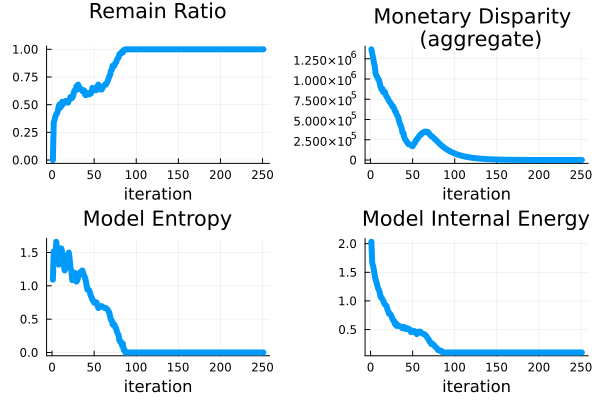

In [81]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )
p3 = Plots.plot( model_df[!,:ModelEntropy], linewidth=6, legend=false,
            title="Model Entropy", xlabel="iteration" )
p4 = Plots.plot( model_df[!,:ModelInternalEnergy], linewidth=6, legend=false,
            title="Model Internal Energy", xlabel="iteration" )


pOveral = Plots.plot([p1,p2,p3,p4]..., layout=grid(2,2) )

In [65]:
gini_internal_U = []
gini_kinetic = []
percentage_remain = []
kinetic_means = []

Any[]

In [66]:
for step in 1:step_num
    agent_U_vals = agent_df[isequal.(agent_df.step, step), :][!,:potential_energy]
    gini = GiniCoefficientJulia( agent_U_vals )
    push!(gini_internal_U,gini)
    push!(percentage_remain, length( findall( agent_U_vals .== 0 ) ) / TOTAL_AGENTS )
    
    agent_K_vals = agent_df[isequal.(agent_df.step, step), :][!,:kinetic_energy]
    agent_K_groups = (KineticEnergy(MAX_MONEY)/100) .* div.(agent_K_vals, KineticEnergy(MAX_MONEY)/100 ) 
    
    if( length(findall( agent_K_vals .< 0 )) > 0 )
        println("BAD")
        println(agent_K_vals)
    end
    gini = GiniCoefficientJulia( agent_K_groups )
    push!(gini_kinetic,gini)
    push!(kinetic_means, mean(agent_K_vals))
end

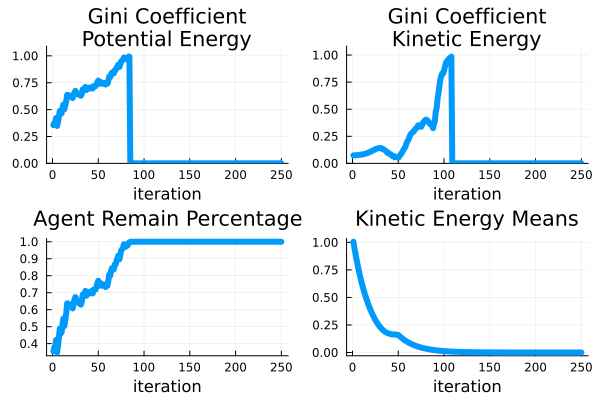

In [67]:
p1_gini = Plots.plot(gini_internal_U, linewidth=6, legend=false,
            title="Gini Coefficient\nPotential Energy", xlabel="iteration",
            ylim=ylim=[0,maximum(gini_internal_U)*1.1])
p2_gini = Plots.plot(gini_kinetic, linewidth=6, legend=false,
                title="Gini Coefficient\nKinetic Energy", xlabel="iteration",
                ylim=[0,maximum(gini_kinetic)*1.1])
p3_gini = Plots.plot(percentage_remain, linewidth=6, legend=false,
                title="Agent Remain Percentage", xlabel="iteration" )
p4_gini = Plots.plot(kinetic_means, linewidth=6, legend=false,
                title="Kinetic Energy Means", xlabel="iteration" )
p_gini = Plots.plot([p1_gini,p2_gini,p3_gini,p4_gini]...,layout=grid(2,2))

In [68]:
using Colors
using ColorSchemes

In [88]:
function number_to_thermal_color(n::Float64)
    color_scheme = ColorSchemes.Paired_8
    rangescale =(-2_000, 4_000)
    # color_scheme = ColorScheme([RGB{Float64}(i, i, i) for i in -41_000:20_000:333_333])
    # Use the number to get a color from the scheme
    color = get(color_scheme, n, rangescale)    
    return color
end

number_to_thermal_color (generic function with 2 methods)

In [82]:
function FinanceColor(agent) 
    money_change = agent.money_change
    return number_to_thermal_color(money_change)
end

FinanceColor (generic function with 1 method)

In [76]:
groupcolor(a) = a.group
groupmarker(a) = a.dispersed_agent == true ? :circle : :rect
groupsize(a) = a.pos_neg_neutral_change 

groupsize (generic function with 1 method)

In [29]:
GLMakie.activate!(inline=false)

In [ ]:
injection_map, _ = Agents.abmplot( model ; ac = FinanceColor, am = groupmarker, as = 25,
                            axis = (; title = "Injection Map", titlesize=20, xticks=(0:1:13), yticks=(0:1:13)))
injection_map



In [89]:
model = initialize()

fig, _ = Agents.abmexploration(model; 
                agent_step!,
                model_step!,
                ac=FinanceColor, am=groupmarker, as = 35,
                figure=(;resolution=(600,600)),
                axis = (;xticks=(0:1:13), yticks=(0:1:13))
                )
display(fig)

GLMakie.Screen(...)

In [ ]:
model = initialize()

set_theme!()

fig, _ = Agents.abmvideo("pos_neg_injection_ripple.mp4", model, 
                agent_step!,
                model_step!;
                ac=FinanceColor, am=groupmarker, as = 25,
                framerate = 1,
                frames = 75,
                title="Speed of Sound Ripple",
                axis = (;xticks=(0:1:13), yticks=(0:1:13))
                )
